In [2]:
# Importing library
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading dataframe
file = "input_data/Tricount.csv"
df = pd.read_csv(file)

In [4]:
# Quick view of the dataframe
df.head()

,Titre,Montant,Devise,Taux de change,Montant dans la devise du tricount (EUR),Type de transaction,Catégorie,Payé par,Payé par Candice,Payé par Nicky,Impacté à Candice,Impacté à Nicky,Date & heure,URL des images
0,Équilibre tt,108.45,EUR,1.0,108.45,Dépense,NaN,Candice,108.45,0.00,0.00,-108.45,29/09/2021 11:03,NaN
1,Antimoustique +mozza,18.40,EUR,1.0,18.40,Dépense,NaN,Nicky,0.00,18.40,-9.20,-9.20,30/09/2021 14:00,NaN
2,Carnet timbre,12.96,EUR,1.0,12.96,Dépense,NaN,Nicky,0.00,12.96,-6.48,-6.48,01/10/2021 13:24,NaN
3,Courses,110.00,EUR,1.0,110.00,Dépense,NaN,Nicky,0.00,110.00,-55.00,-55.00,02/10/2021 00:22,NaN
4,Fleur,17.20,EUR,1.0,17.20,Dépense,NaN,Candice,17.20,0.00,-8.60,-8.60,03/10/2021 12:07,NaN


In [5]:
# Dropping useless columns with NaN Values
df.dropna(axis = 1, how = 'all', inplace = True)
# Drop column with no real informations
df.drop(["Taux de change","Devise","Type de transaction","Montant dans la devise du tricount (EUR)"],axis = 1,inplace = True)
# Setting date and time as index
df['Datetime'] = pd.to_datetime(df["Date & heure"], format = "%d/%m/%Y %H:%M")
df.drop("Date & heure",axis = 1,inplace = True)
df.set_index('Datetime',inplace = True, drop= True)
# Dropping rows for year 2021 (which is not a complete year)
df = df.loc[df.index.year == 2022,:]
# Dropping rows which correspond to unusual expense
df.drop(df[df["Montant"]>250].index, axis = 0,inplace = True)
# Sorting dataframe by ascending date
df.sort_index(inplace = True)

          sum_expense
Datetime             
1              831.85
2              595.83
3              673.89
4              687.94
5              827.33
6              988.18
7             1320.64
8              499.54
9              912.85
10            1319.12
11            1485.71
12             755.04


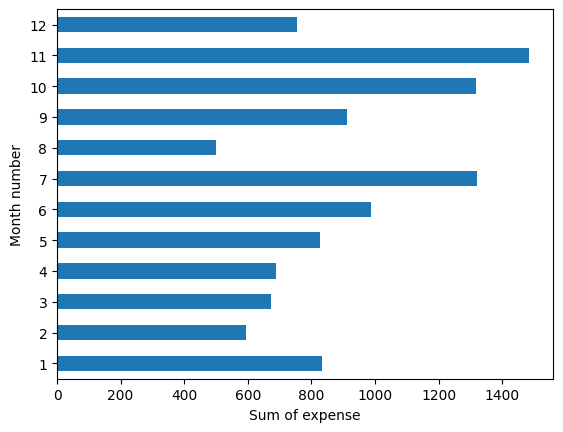

In [6]:
# Looking for all the expense inputed in Tricount for each month
df.groupby(df.index.month)["Montant"].sum().plot.barh(xlabel = "Sum of expense",ylabel = "Month number");
print(df.groupby(df.index.month).agg(sum_expense=('Montant', 'sum')))

<AxesSubplot: xlabel='Datetime', ylabel='Montant'>

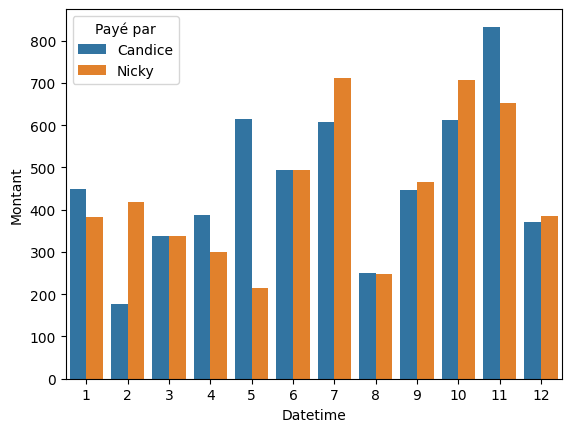

In [7]:
# Same plot with distinction between users
df_temp = df.groupby(["Payé par",df.index.month])["Montant"].sum().reset_index()
sns.barplot(data = df_temp,x = "Datetime", y = "Montant", hue = "Payé par")

In [8]:
# Creating categories for main expense 
df["Category"] = "Others"
# Groceries category
df.loc[df["Titre"].str.contains("[Cc]ourse",regex = True),"Category"] = "Groceries"
df.loc[df["Titre"].str.contains("[Mm]arch",regex = True),"Category"] = "Groceries"
df.loc[df["Titre"].str.contains("Pain",regex = True),"Category"] = "Groceries"
df.loc[df["Titre"].str.contains("Boulangerie",regex = True),"Category"] = "Groceries"

# Rental charges
df.loc[df["Titre"].str.contains("[eEéÉ]lec",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Gg]az",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Ii]ntern",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Ss][Ff][Rr]",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Aa]ssurance [Mm]aison",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Aa]ssurance [hH]abitation",regex = True),"Category"] = "Rental_charge"
df.loc[df["Titre"].str.contains("[Aa]ssurance [lL]ocation",regex = True),"Category"] = "Rental_charge"

# Car expense
df.loc[df["Titre"].str.contains("[eEéÉ]ssence",regex = True),"Category"] = "Car_expense"
df.loc[df["Titre"].str.contains("Assurance auto"),"Category"] = "Car_expense"
df.loc[df["Titre"].str.contains("oitur"),"Category"] = "Car_expense"


<AxesSubplot: xlabel='Month_number'>

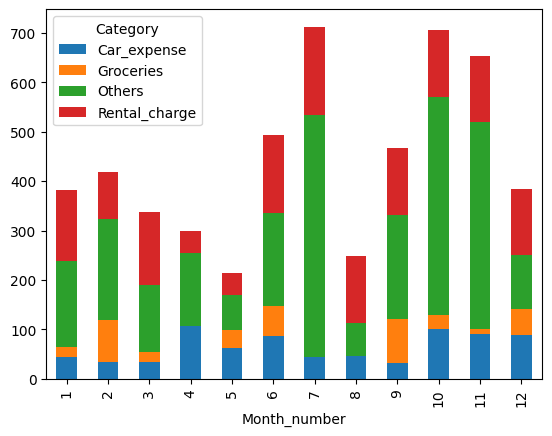

In [9]:
# Plot expense details for Nicky
df_nicky = df[df["Payé par"]=="Nicky"]
df_plot = df_nicky.groupby([df_nicky.index.month,"Category"])["Payé par Nicky"].sum().reset_index()
df_plot.columns = ["Month_number","Category","Amount"]
df_plot = df_plot.pivot(index = "Month_number",columns = "Category",values = "Amount")
df_plot.plot(kind = "bar", stacked = True)

<AxesSubplot: xlabel='Month_number'>

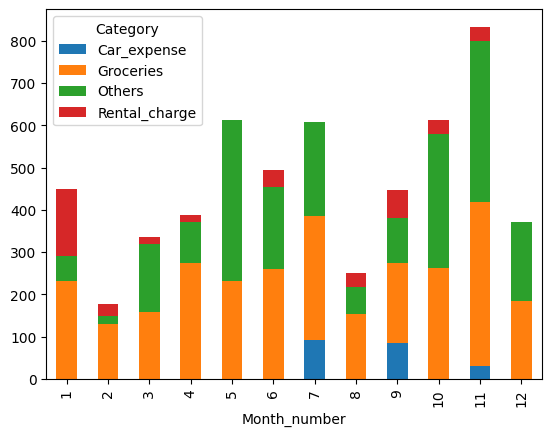

In [10]:
# Plot expense details for Candice

df_candice = df[df["Payé par"]=="Candice"]
df_plot = df_candice.groupby([df_candice.index.month,"Category"])["Payé par Candice"].sum().reset_index()
df_plot.columns = ["Month_number","Category","Amount"]
df_plot = df_plot.pivot(index = "Month_number",columns = "Category",values = "Amount")
df_plot.plot(kind = "bar", stacked = True)

In [11]:
# Define mean budget for Nicky
df_budget = df_nicky.groupby(["Category",df_nicky.index.month])["Payé par Nicky"].sum().reset_index()
df_budget = df_budget.groupby("Category")["Payé par Nicky"].mean().reset_index()
print(df_budget)
sum_budget = df_budget["Payé par Nicky"].sum()
print(f"Budget pour Nicky = {sum_budget}")

        Category  Payé par Nicky
0    Car_expense       64.321667
1      Groceries       44.527778
2         Others      221.265000
3  Rental_charge      123.899167
Budget pour Nicky = 454.01361111111106


In [12]:
# Define mean budget for Candice
df_budget = df_candice.groupby(["Category",df_candice.index.month])["Payé par Candice"].sum().reset_index()
df_budget = df_budget.groupby("Category")["Payé par Candice"].mean().reset_index()
print(df_budget)
sum_budget = df_budget["Payé par Candice"].sum()
print(f"Budget pour Candice = {sum_budget}")

        Category  Payé par Candice
0    Car_expense         69.550000
1      Groceries        229.627500
2         Others        182.739167
3  Rental_charge         47.365556
Budget pour Candice = 529.2822222222222
